In [17]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import sklearn.metrics as skm
import matplotlib.pyplot as plt
from TreeBasedMethods import *
from optimizer_functions import logistic_regression_sgd
import seaborn as sns
from activation_functions import *
from optimizer_functions import *
from cost_functions import *
from Layer import Layer
from NeuralNetwork import NeuralNetwork
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score as accuracy

In [6]:
# returns list of all metrics given the predicted probability and real class

def classification_metrics(prob_pred,y_test):

    tn, fp, fn, tp = skm.confusion_matrix(y_test, prob_pred.round()).ravel()

    acc = (tp+tn)/(tp+tn+fp+fn)
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    specificity = tn/(tn+fp)
    fscore = 2*(precision*recall)/(precision+recall)
    auc = skm.roc_auc_score(y_test, prob_pred)

    return [acc, precision, recall, specificity, fscore, auc]

## Data cleaning

In [7]:
# importing Pima Indians Diabetes dataset
df = pd.read_csv('diabetes.csv')

In [8]:
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [9]:
# replacing inaccurate values with mean
df[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']] = df[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']].replace(0,np.NaN)
df['Glucose'].fillna(df['Glucose'].mean(), inplace = True)
df['BloodPressure'].fillna(df['BloodPressure'].mean(), inplace = True)
df['SkinThickness'].fillna(df['SkinThickness'].mean(), inplace = True)
df['Insulin'].fillna(df['Insulin'].mean(), inplace = True)
df['BMI'].fillna(df['BMI'].mean(), inplace = True)

df = df.rename(columns={"Pregnancies": "Preg", 'BloodPressure': "Press", "SkinThickness": "Skin", "DiabetesPedigreeFunction": "DPF"})

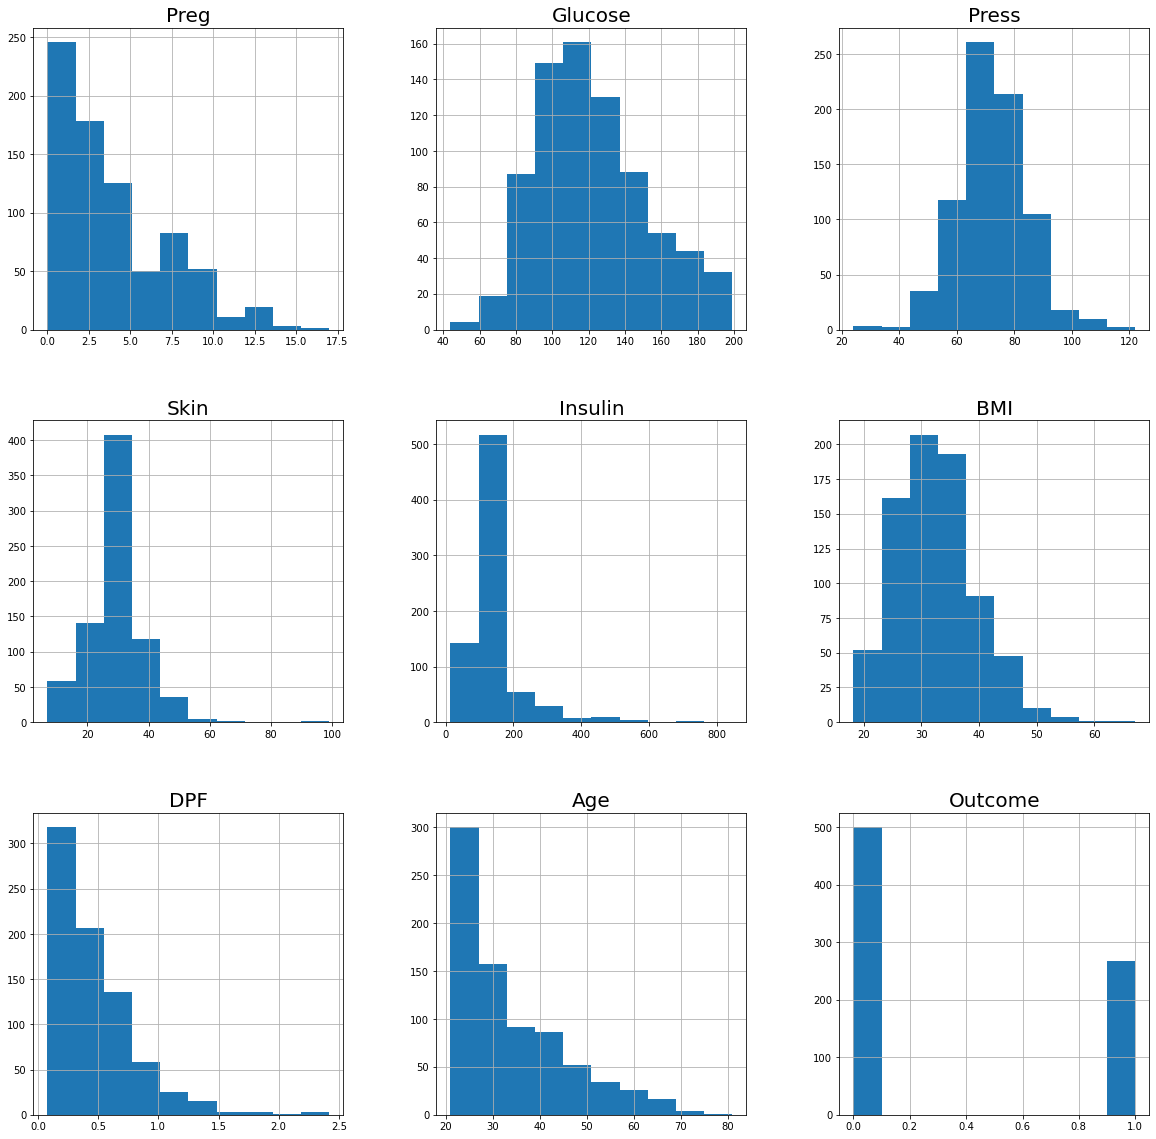

In [10]:
fig = df.hist(figsize=(20, 20))
[x.title.set_size(20) for x in fig.ravel()]
plt.savefig("Variable histogram.png")

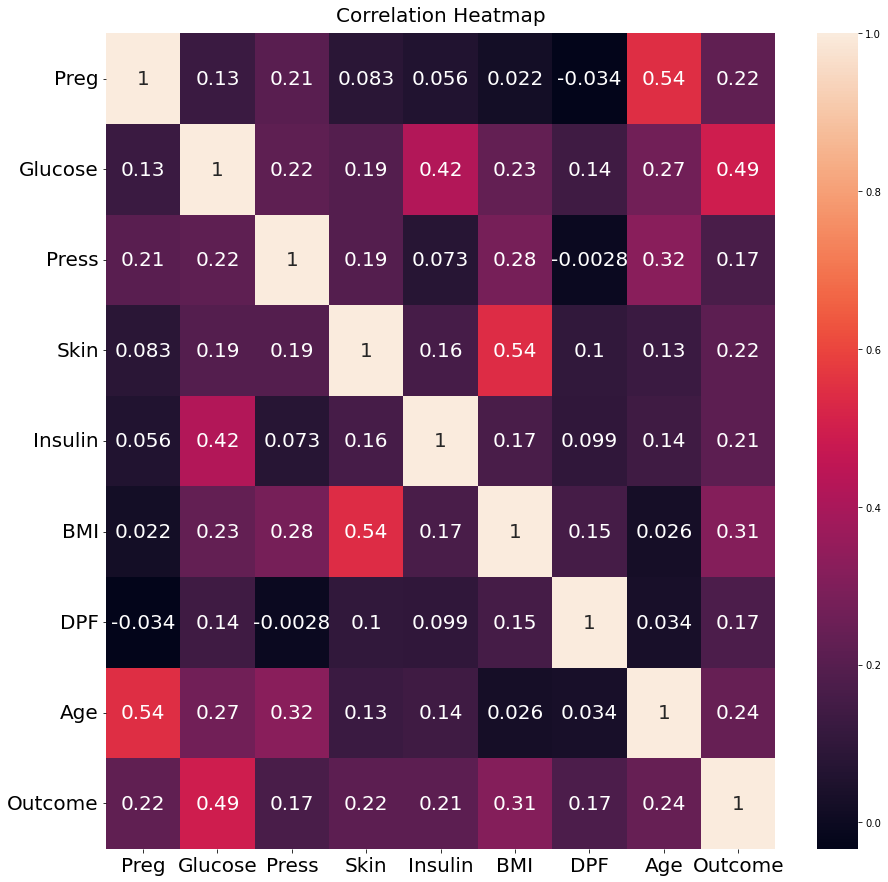

In [11]:
fig = plt.figure(figsize=(15,15))
heatmap = sns.heatmap(df.corr(), annot=True,annot_kws={'fontsize':20})
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':20}, pad=12)
heatmap.set_xticklabels(heatmap.get_xmajorticklabels(),fontsize=20)
heatmap.set_yticklabels(heatmap.get_ymajorticklabels(),fontsize=20,rotation=0)
plt.savefig("Correlation heatmap.png")
plt.show()

In [12]:
# splitting in train and test 

X = df.drop('Outcome',axis=1)
y = df['Outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=1)

In [13]:
# scaling

from sklearn.preprocessing import StandardScaler

sc = StandardScaler().fit(X_train)
X_train = sc.transform(X_train)
X_test = sc.transform(X_test)

## Comparing implementation

In [ ]:
# comparison performance our implementation and sklearn

y_train_comp = y_train.values*2-1
y_test_comp = y_test.values*2-1

clf = DecisionTreeClass(max_depth=200)
clf.fit(X_train, y_train_comp)

y_pred = clf.predict(X_test)
acc = accuracy(y_test_comp, y_pred)

print("Our implementation tree:", acc)

print("Sklearn tree:", DecisionTreeClassifier(max_depth=200).fit(X_train,y_train).score(X_test,y_test))

model = RandomForest(num_trees=200)
model.fit(X_train, y_train_comp)
preds = model.predict(X_test)

acc = accuracy(y_test_comp, preds)

print("Our implementation Random forest:", acc)

print("Sklearn Random forest:", RandomForestClassifier(n_estimators=200).fit(X_train,y_train).score(X_test,y_test))

model = AdaBoost()
model.fit(X_train, y_train_comp, M=200)
preds = model.predict(X_test)

acc = accuracy(y_test_comp, preds)

print("Our implementation AdaBoost:", acc)

print("Sklearn AdaBoost:", AdaBoostClassifier(n_estimators=200).fit(X_train,y_train).score(X_test,y_test))

## Tuning method's parameters and studying performance

### Tree-based methods

In [14]:
from sklearn.tree import DecisionTreeClassifier

dec_tree = DecisionTreeClassifier()

In [ ]:
# compute train and test error for different values of cost-complexity parameter

alphas = dec_tree.cost_complexity_pruning_path(X_train,y_train)['ccp_alphas']
len_alphas = len(alphas)

train_err_dec_tree = np.zeros(len_alphas)
test_err_dec_tree = np.zeros(len_alphas)

for i in range(len_alphas):
    a = alphas[i]
    dec_tree.ccp_alpha = a
    dec_tree.fit(X_train,y_train)
    train_err_dec_tree[i] = dec_tree.score(X_train,y_train)
    test_err_dec_tree[i] = dec_tree.score(X_test,y_test)

In [ ]:
fig = plt.figure(figsize = (10,8))
plt.plot(alphas,train_err_dec_tree, label = 'Training accuracy')
plt.plot(alphas,test_err_dec_tree, label = 'Test accuracy')
plt.legend(fontsize=15)
plt.xlim((-0.002,0.04))
plt.xlabel("Alpha", fontsize=15)
plt.ylabel("Accuracy", fontsize=15)
plt.title("Train and test accuracy for classification tree", fontsize=15)
plt.show()
#plt.savefig("Train and test accuracy for classification tree.png")

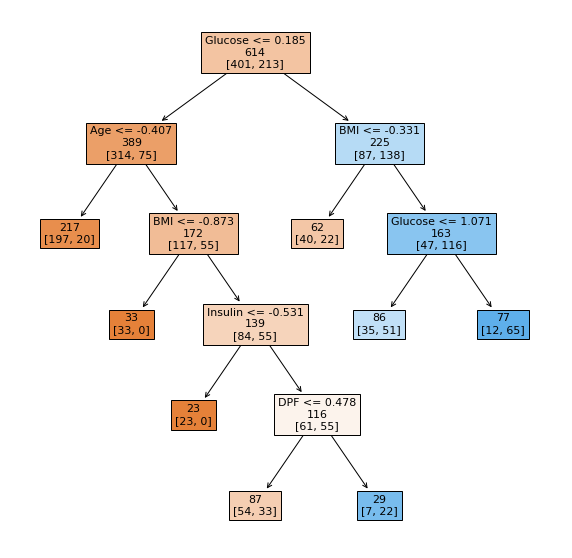

In [32]:
dt = DecisionTreeClassifier(ccp_alpha=0.006).fit(X_train,y_train)
fig = plt.figure(figsize=(10,10))
plot_tree(dt,feature_names=df.columns,impurity=False, label='none', fontsize=11, filled=True)
#plt.savefig("Pruned tree.png")
plt.show()

In [ ]:
# compare ensemble methods with increasing number of trees and unpruned tree

unpruned_tree_acc = DecisionTreeClassifier().fit(X_train,y_train).score(X_test,y_test)

ntrees_v = range(1,801,5)
rf = RandomForestClassifier()
ab = AdaBoostClassifier()

test_err_rf = []
test_err_ab = []

for n in ntrees_v:

    rf.n_estimators = int(n)
    rf.fit(X_train,y_train)
    test_err_rf.append(rf.score(X_test,y_test))

    ab.n_estimators = int(n)
    ab.fit(X_train,y_train)
    test_err_ab.append(ab.score(X_test,y_test))

In [ ]:
fig = plt.figure(figsize = (10,8))
plt.plot(ntrees_v,test_err_rf, label = 'Random Forest')
plt.plot(ntrees_v,test_err_ab, label = 'Adaboost')
plt.hlines(unpruned_tree_acc,-10,801, colors = 'green', label = 'Unpruned tree',linestyles='dashed')
plt.legend(fontsize=12)
plt.xlabel("Number of trees",fontsize=15)
plt.ylabel("Accuracy",fontsize=15)
plt.title("Test accuracy for ensemble methods with different number of trees",fontsize=15)
plt.show()
#plt.savefig("Test accuracy for ensemble methods with different number of trees.png")

In [ ]:
# accuracy rf changing number of predictors at each split

n_vars = range(1,9)

rf = RandomForestClassifier(n_estimators=100)

test_err_rf = []

for n in n_vars:

    rf.max_features = n
    rf.fit(X_train,y_train)
    test_err_rf.append(rf.score(X_test,y_test))

In [ ]:
fig = plt.figure(figsize = (10,8))
plt.plot(n_vars,test_err_rf)
plt.xlabel("Number of predictors at each split", fontsize=15)
plt.ylabel("Accuracy", fontsize=15)
plt.title("Random Forest changing number of predictors considered at each split", fontsize=15)
plt.show()
#plt.savefig("Random Forest changing number of predictors considered at each split.png")

In [ ]:
# roc curves

dt = DecisionTreeClassifier(ccp_alpha=0.006).fit(X_train,y_train)
dt_probs = dt.predict_proba(X_test)[:,1]
dt_fpr, dt_tpr, _ = skm.roc_curve(y_test, dt_probs)
dt_roc_auc = skm.roc_auc_score(y_test, dt_probs)

rf = RandomForestClassifier(n_estimators=100).fit(X_train,y_train)
rf_probs = rf.predict_proba(X_test)[:,1]
rf_fpr, rf_tpr, _ = skm.roc_curve(y_test, rf_probs)
rf_roc_auc = skm.roc_auc_score(y_test, rf_probs)

ab = AdaBoostClassifier(n_estimators=100).fit(X_train,y_train)
ab_probs = ab.predict_proba(X_test)[:,1]
ab_fpr, ab_tpr, _ = skm.roc_curve(y_test, ab_probs)
ab_roc_auc = skm.roc_auc_score(y_test, ab_probs)

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(dt_fpr,dt_tpr,color="darkorange",label="Decision tree (AUC = %0.2f)" % dt_roc_auc)
plt.plot(rf_fpr,rf_tpr,color="green",label="Random forest (AUC = %0.2f)" % rf_roc_auc)
plt.plot(ab_fpr,ab_tpr,color="red",label="AdaBoost (AUC = %0.2f)" % ab_roc_auc)
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate",fontsize=15)
plt.ylabel("True Positive Rate",fontsize=15)
plt.title("ROC curve for tree-based methods",fontsize=15)
plt.legend(loc="lower right",fontsize=15)
#plt.savefig("ROC curve for tree-based methods.png")
plt.show()

In [ ]:
# variable importance with random forest

rf = RandomForestClassifier(n_estimators=100).fit(X_train,y_train)
rf_importances = rf.feature_importances_
rf_std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

In [ ]:
fig = plt.figure(figsize=(10,8))
plt.bar(X.columns,rf_importances, yerr=rf_std)
plt.xticks(rotation=60,fontsize=15)
plt.xlabel("",fontsize=15)
plt.ylabel("Relative importance",fontsize=15)
plt.title("Variable importance from Random Forest ensemble",fontsize=15)
plt.savefig("Variable importance from Random Forest ensemble.png")
plt.show()

In [ ]:
# metrics table with all variables: Accuracy (%) Precision (%) Sensitivity (%) Specificity (%) F-score (%) AUC (%)

dt_metrics = classification_metrics(dt.predict_proba(X_test)[:,1],y_test)
rf_metrics = classification_metrics(rf.predict_proba(X_test)[:,1],y_test)
ab_metrics = classification_metrics(ab.predict_proba(X_test)[:,1],y_test)

In [ ]:
metrics_table = pd.DataFrame(columns = ['Accuracy', 'Precision', 'Recall', 'Specificity', 'F-Score', 'AUC'])
metrics_table.loc['Decision Tree'] = dt_metrics
metrics_table.loc['Random Forest'] = rf_metrics
metrics_table.loc['AdaBoost'] = ab_metrics
metrics_table

In [ ]:
# metrics selecting 2 variables (Glucose and BMI)

X_train_2 = X_train[:,[1,5]]
X_test_2 = X_test[:,[1,5]]

dt_2 = DecisionTreeClassifier(ccp_alpha=0.01).fit(X_train_2,y_train)
rf_2 = RandomForestClassifier(n_estimators=100).fit(X_train_2,y_train)
ab_2 = AdaBoostClassifier(n_estimators=100).fit(X_train_2,y_train)

dt_2_metrics = classification_metrics(dt_2,X_test_2,y_test)
rf_2_metrics = classification_metrics(rf_2,X_test_2,y_test)
ab_2_metrics = classification_metrics(ab_2,X_test_2,y_test)

In [ ]:
metrics_table_2 = pd.DataFrame(columns = ['Accuracy', 'Precision', 'Recall', 'Specificity', 'F-Score', 'AUC'])
metrics_table_2.loc['Decision Tree'] = dt_2_metrics
metrics_table_2.loc['Random Forest'] = rf_2_metrics
metrics_table_2.loc['AdaBoost'] = ab_2_metrics
metrics_table_2

### Logistic Regression

In [ ]:
# grid search best parameters logistic regression

# tuning learning rate and regularization parameter

y_train_log = y_train.values
y_test_log = y_test.values

eta_list = [0.001, 0.01, 0.02, 0.05, 0.07, 0.09]
reg_list = [0, 0.01, 0.1, 1, 10]
accuracy_mat = np.zeros((len(reg_list),len(eta_list)))

for j in range(len(eta_list)):
    for i in range(len(reg_list)):
       
        reg = reg_list[i]
        eta = eta_list[j]

        betas = logistic_regression_sgd(X_train, y_train_log, eta, reg, 200, 50)
        ypred = (sigmoid(X_test @ betas)>=0.5)
        accuracy_mat[i][j] = sum(y_test_log == ypred)/np.shape(y_test)[0]

In [ ]:
plt.figure(figsize=(15,10))
heatmap = sns.heatmap(accuracy_mat, xticklabels=eta_list, yticklabels=reg_list, annot=True, annot_kws={"size": 20}, fmt=".3f")
plt.ylabel("Regularization parameter", fontsize=20)
plt.xlabel("Learning rate", fontsize=20)
heatmap.set_xticklabels(heatmap.get_xmajorticklabels(),fontsize=20)
heatmap.set_yticklabels(heatmap.get_ymajorticklabels(),fontsize=20,rotation=0)
plt.title("Accuracy grid search for learning rate and regularization parameter for logistic regression", fontsize=20)
#plt.savefig("logreg_accuracy_lr_nn_grid_search.png")

### Neural Network

In [ ]:
# tuning learning rate and regularization parameter

y_train_nn = y_train.values.reshape(len(y_train),1)
y_test_nn = y_test.values.reshape(len(y_test),1)

eta_list = [0.001, 0.01, 0.02, 0.05, 0.075]
reg_list = [0, 0.01, 0.1, 1, 10]
accuracy_mat_nn = np.zeros((len(reg_list),len(eta_list)))

for j in range(len(eta_list)):
    for i in range(len(reg_list)):
       
        reg = reg_list[i]
        eta = eta_list[j]

        nn = NeuralNetwork(8, class_cost_grad,random_state=1)
        layer1 = Layer(30, sigmoid, sigmoid_grad)
        layer2 = Layer(1, sigmoid, sigmoid_grad)
        nn.add_layer(layer1)
        nn.add_layer(layer2)
        nn.train(X_train,y_train_nn,eta=eta,regularization=reg, epochs=100)

        pred = nn.feed_forward_out(X_test)
        pred = pred.round()
        accuracy_mat_nn[i][j] = np.sum(pred == y_test_nn)/y_test.shape[0]

In [ ]:
plt.figure(figsize=(15,10))
heatmap = sns.heatmap(accuracy_mat_nn, xticklabels=eta_list, yticklabels=reg_list, annot=True, annot_kws={"size": 20}, fmt=".3f")
plt.ylabel("Regularization parameter", fontsize=20)
plt.xlabel("Learning rate", fontsize=20)
heatmap.set_xticklabels(heatmap.get_xmajorticklabels(),fontsize=20)
heatmap.set_yticklabels(heatmap.get_ymajorticklabels(),fontsize=20,rotation=0)
plt.title("Accuracy grid search for learning rate and regularization parameter", fontsize=20)
#plt.savefig("accuracy_grid_search.png")

In [ ]:
# tuning learning rate and number of neurons

eta_list = [0.001, 0.01, 0.02, 0.05, 0.075]
n_neurons_list = [10, 20, 30, 50]
accuracy_mat_nn = np.zeros((len(eta_list),len(n_neurons_list)))

for j in range(len(eta_list)):
    for i in range(len(n_neurons_list)):
       
        n_neurons = n_neurons_list[i]
        eta = eta_list[j]

        nn = NeuralNetwork(8,class_cost_grad,random_state=1)
        layer1 = Layer(n_neurons, sigmoid, sigmoid_grad)
        layer2 = Layer(1, sigmoid, sigmoid_grad)
        nn.add_layer(layer1)
        nn.add_layer(layer2)
        nn.train(X_train,y_train_nn,eta=eta, epochs=200)

        pred = nn.feed_forward_out(X_test)
        pred = pred.round()
        accuracy_mat_nn[j][i] = np.sum(pred == y_test_nn)/y_test.shape[0]

In [ ]:
plt.figure(figsize=(15,10))
heatmap = sns.heatmap(accuracy_mat_nn.T, xticklabels=eta_list, yticklabels=n_neurons_list, annot=True, annot_kws={"size": 20}, fmt=".3f")
plt.ylabel("Number of neurons", fontsize=20)
plt.xlabel("Learning rate", fontsize=20)
heatmap.set_xticklabels(heatmap.get_xmajorticklabels(),fontsize=20)
heatmap.set_yticklabels(heatmap.get_ymajorticklabels(),fontsize=20,rotation=0)
plt.title("Accuracy grid search for learning rate and number of neurons", fontsize=20)
#plt.savefig("accuracy_lr_nn_grid_search.png")

In [ ]:
# different number of hidden layers

n_epochs = 100
eta = 0.05
step = 5

nn_1 = NeuralNetwork(8,class_cost_grad,random_state=1)
nn_2 = NeuralNetwork(8,class_cost_grad,random_state=1)
nn_3 = NeuralNetwork(8,class_cost_grad,random_state=1)
layer11 = Layer(20,sigmoid,sigmoid_grad)
layer21 = Layer(1,sigmoid,sigmoid_grad)
layer12 = Layer(20,sigmoid,sigmoid_grad)
layer22 = Layer(20,sigmoid,sigmoid_grad)
layer32 = Layer(1,sigmoid,sigmoid_grad)
layer13 = Layer(20,sigmoid,sigmoid_grad)
layer23 = Layer(20,sigmoid,sigmoid_grad)
layer33 = Layer(20,sigmoid,sigmoid_grad)
layer43 = Layer(1,sigmoid,sigmoid_grad)

nn_1.add_layer(layer11)
nn_1.add_layer(layer21)
nn_2.add_layer(layer12)
nn_2.add_layer(layer22)
nn_2.add_layer(layer32)
nn_3.add_layer(layer13)
nn_3.add_layer(layer23)
nn_3.add_layer(layer33)
nn_3.add_layer(layer43)

acc_1 = []
acc_2 = []
acc_3 = []


for i in range(0,n_epochs,step):
    
    acc_1.append(np.sum(nn_1.feed_forward_out(X_test).round() == y_test_nn)/y_test_nn.shape[0])
    acc_2.append(np.sum(nn_2.feed_forward_out(X_test).round() == y_test_nn)/y_test_nn.shape[0])
    acc_3.append(np.sum(nn_3.feed_forward_out(X_test).round() == y_test_nn)/y_test_nn.shape[0])
    nn_1.train(X_train,y_train_nn,eta=eta,epochs=step, minibatch_size = 20)
    nn_2.train(X_train,y_train_nn,eta=eta,epochs=step, minibatch_size = 20)
    nn_3.train(X_train,y_train_nn,eta=eta,epochs=step, minibatch_size = 20)

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(range(0,n_epochs,step),acc_1,label='1 hidden layer')
plt.plot(range(0,n_epochs,step),acc_2,label='2 hidden layers')
plt.plot(range(0,n_epochs,step),acc_3,label='3 hidden layers')
plt.legend(fontsize=15)
plt.title("Accuracy vs Epochs", fontsize=15)
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("Accuracy", fontsize=15)
#plt.savefig("class_number_of_hidden_layers.png")

In [ ]:
# different activation functions

n_epochs = 200
step = 5
eta = 0.05

nn_sigm = NeuralNetwork(8, class_cost_grad,random_state=1)
nn_relu = NeuralNetwork(8, class_cost_grad,random_state=1)
nn_lrelu = NeuralNetwork(8, class_cost_grad,random_state=1)
nn_tanh = NeuralNetwork(8, class_cost_grad,random_state=1)
layer1sigm = Layer(20,sigmoid,sigmoid_grad)
layer2sigm= Layer(1,sigmoid,sigmoid_grad)
layer1relu = Layer(20,ReLU,ReLU_grad)
layer2relu = Layer(1,sigmoid,sigmoid_grad)
layer1lrelu = Layer(20,leakyReLU,leakyReLU_grad)
layer2lrelu = Layer(1,sigmoid,sigmoid_grad)
layer1tanh = Layer(20,tanh,tanh_grad)
layer2tanh = Layer(1,sigmoid,sigmoid_grad)
nn_sigm.add_layer(layer1sigm)
nn_sigm.add_layer(layer2sigm)
nn_relu.add_layer(layer1relu)
nn_relu.add_layer(layer2relu)
nn_lrelu.add_layer(layer1lrelu)
nn_lrelu.add_layer(layer2lrelu)
nn_tanh.add_layer(layer1tanh)
nn_tanh.add_layer(layer2tanh)

acc_sigm = []
acc_relu = []
acc_lrelu = []
acc_tanh = []

for i in range(0,n_epochs,step):
    acc_sigm.append(np.sum(nn_sigm.feed_forward_out(X_test).round() == y_test_nn)/y_test.shape[0])
    acc_relu.append(np.sum(nn_relu.feed_forward_out(X_test).round() == y_test_nn)/y_test.shape[0])
    acc_lrelu.append(np.sum(nn_lrelu.feed_forward_out(X_test).round() == y_test_nn)/y_test.shape[0])
    acc_tanh.append(np.sum(nn_tanh.feed_forward_out(X_test).round() == y_test_nn)/y_test.shape[0])
    nn_sigm.train(X_train,y_train_nn,eta=eta,epochs=step)
    nn_relu.train(X_train,y_train_nn,eta=eta,epochs=step)
    nn_lrelu.train(X_train,y_train_nn,eta=eta,epochs=step)
    nn_tanh.train(X_train,y_train_nn,eta=eta,epochs=step)

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(range(0,n_epochs,step),acc_sigm,label='Sigmoid')
plt.plot(range(0,n_epochs,step),acc_relu,label='ReLU')
plt.plot(range(0,n_epochs,step),acc_lrelu,label='Leaky ReLU')
plt.plot(range(0,n_epochs,step),acc_tanh,label='Tanh')
plt.legend(fontsize=15)
plt.title("Test accuracy vs Epochs for different activation functions", fontsize=15)
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("Accuracy", fontsize=15)
#plt.savefig("class_nn_activation_functions.png")

In [ ]:
# roc curves

betas = logistic_regression_sgd(X_train, y_train_log, 0.001, 1, 200, 50)
lr_probs = sigmoid(X_test @ betas)
lr_fpr, lr_tpr, _ = skm.roc_curve(y_test, lr_probs)
lr_roc_auc = skm.roc_auc_score(y_test, lr_probs)

nn = NeuralNetwork(8, class_cost_grad, random_state=1)
layer1 = Layer(20, sigmoid, sigmoid_grad)
layer2 = Layer(20, sigmoid, sigmoid_grad)
layer3 = Layer(1, sigmoid, sigmoid_grad)
nn.add_layer(layer1)
nn.add_layer(layer2)
nn.add_layer(layer3)
nn.train(X_train, y_train_nn, eta=0.05, epochs=200)
nn_probs = nn.feed_forward_out(X_test)
nn_fpr, nn_tpr, _ = skm.roc_curve(y_test, nn_probs)
nn_roc_auc = skm.roc_auc_score(y_test, nn_probs)

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(dt_fpr,dt_tpr,color="darkorange",label="Logistic Regression (AUC = %0.2f)" % lr_roc_auc)
plt.plot(rf_fpr,rf_tpr,color="green",label="Neural Network (AUC = %0.2f)" % nn_roc_auc)
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate",fontsize=15)
plt.ylabel("True Positive Rate",fontsize=15)
plt.title("ROC curves for Neural Network and Logistic Regression",fontsize=15)
plt.legend(loc="lower right",fontsize=15)
plt.savefig("ROC curves for Neural Network and Logistic Regression.png")
plt.show()

In [ ]:
lr_metrics = classification_metrics(lr_probs,y_test)
nn_metrics = classification_metrics(nn_probs,y_test)

### Final comparison

In [ ]:
metrics_table = pd.DataFrame(columns = ['Accuracy', 'Precision', 'Recall', 'Specificity', 'F-Score', 'AUC'])
metrics_table.loc['Decision Tree'] = dt_metrics
metrics_table.loc['Random Forest'] = rf_metrics
metrics_table.loc['AdaBoost'] = ab_metrics
metrics_table.loc['Logistic Regression'] = lr_metrics
metrics_table.loc['Neural Network'] = nn_metrics
metrics_table